In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Повторение

## Загрузка и подготовка данных

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/datasets_14872_228180_Admission_Predict_Ver1.1.csv')
del df['Serial No.']

In [6]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
# мало :(
len(df)

500

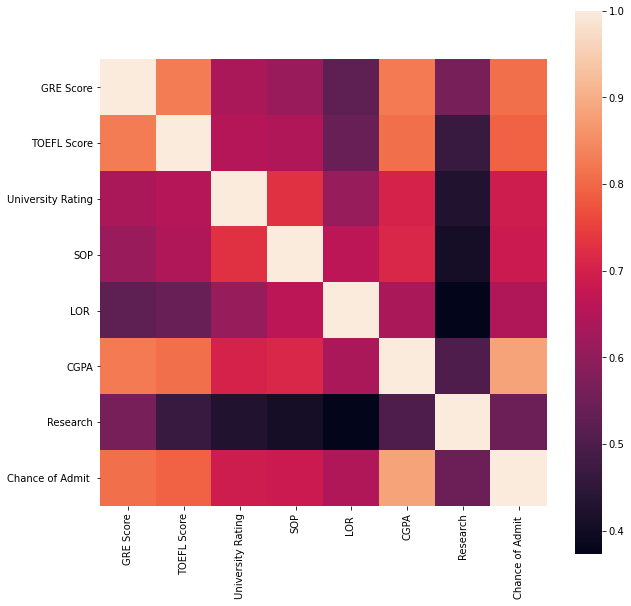

In [8]:
import seaborn as sns

plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), square=True)
plt.show()

In [9]:
# перемешка
df = df.sample(frac=1).reset_index(drop=True)
# train test split
df_train = df[:400]
df_test = df[400:]
# среднее и стандартное отклонение
mean = df.mean(axis=0)
std = df.std(axis=0)
# 0 мат ожидание и 1 дисперсию
df_train = (df_train - mean)/std
X_train = df_train.drop(columns=['Chance of Admit ']).values
y_train = df_train['Chance of Admit '].values
df_test = (df_test - mean)/std
X_test = df_test.drop(columns=['Chance of Admit ']).values
y_test = df_test['Chance of Admit '].values

In [10]:
X_train[:5]

array([[ 0.48941367,  0.46170028,  1.64930524,  1.64076091,  0.55756685,
         0.86565628,  0.88551841],
       [ 1.55181671,  1.94150887,  1.64930524,  1.13622188,  1.0978448 ,
         1.49394986,  0.88551841],
       [-0.30738861, -0.85368513, -0.09969289, -0.88193421, -1.06326701,
         0.17122653, -1.12702343],
       [ 1.6403503 ,  1.61266252,  1.64930524,  1.64076091,  1.63812275,
         2.05610728,  0.88551841],
       [-0.66152296, -0.19599243, -0.97419196, -0.88193421, -1.06326701,
        -0.95308829, -1.12702343]])

In [11]:
y_train[:5]

array([ 1.12129479,  1.5464034 , -0.08317958,  1.68810626, -0.72084249])

## Создание алгоритма

In [13]:
print('размерность пространства признаков:', X_train.shape[1])
# инициализация весов под размерность пространства признаков
w = np.ones(X_train.shape[1])
# выбираем случайный индекс, по которому найдем частную производную
ind = np.random.randint(X_train.shape[1])
print('Случайный индекс', ind)
# переможим выбранный столбец на нужный вес (получаем кол-во элементов train)
len(np.dot(X_train[:,ind], w[ind]))

размерность пространства признаков: 7
Случайный индекс 4


400

$$MSE = \frac{1}{n}\sum_{i = 1}^{n}(y_i - \hat{y_i})^2$$

Реализуем ошибку по формуле:

In [14]:
mse = lambda y, y_pred:((y-y_pred)**2).sum()/len(y_pred)   

In [15]:
# очистка экрана
from google.colab import output
# коэффициент детерминации
from sklearn.metrics import r2_score

Стохастический градиентный спуск (англ. stochastic gradient descent, SGD) − оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента.

![dssmall](https://github.com/m9psy/neural_network_habr_guide/blob/master/Part%203/images/stochastic.gif?raw=true)

$$w_{t+1} = w_{t} - \frac{2\alpha}{n}X_i(<X_i, w_{t}> - y_i) $$

Реализуем шаг по формуле

In [16]:
gradient_step_stah = lambda X, y, w, alpha, ind: w - (alpha* 2.0 / X.shape[0]) * X[ind] * (np.dot(X[ind], w) - y[ind])

In [21]:
# выбрали случайный индекс
ind = np.random.randint(X_train.shape[1])
# сделали один шаг (w = [1, 1, ...])
gradient_step_stah(X_train, y_train, np.ones(X_train.shape[1]),1e-4,ind)

array([0.99999867, 0.99999875, 0.99999552, 0.99999555, 0.99999849,
       0.99999765, 0.9999976 ])

In [22]:
X_train.shape[1]

7

## Обучение алгоритма

In [23]:
# стахостический градиентный спуск
def sgd(X, y, w, alpha = 1e-4, max_it = 10e6):
    # номер итерации
    iter_num = 0
    # ошибки на треине
    errors = []
    # ошибки на тесте
    errors_test = []
    # r2 на тесте
    r2 = []
    while (iter_num < max_it):
        # выбираем случайный элемент
        ind = np.random.randint(X.shape[0])
        # обновляем веса град спуском
        w = gradient_step_stah(X, y, w, alpha, ind)
        # отображаем каждый %
        if iter_num%(int(max_it/100))==0:
            # очищаем экран
            output.clear()
            print('Выполнено:', int(iter_num/max_it * 100), '%')
            # mse train
            error = mse(y_train,np.dot(X_train, w))
            errors.append(error)
            print('Mse train:', error)
            # mse test
            error = mse(y_test,np.dot(X_test, w))
            errors_test.append(error)
            print('Mse test:', error)
            # r2 test
            R = r2_score(y_test,np.dot(X_test, w))
            r2.append(R)
            print('R2:', R)
        iter_num += 1

    return w, errors, errors_test, r2

w, mse_train, mse_test, r2 = sgd(X_train, y_train, np.ones(X_train.shape[1]))

Выполнено: 99 %
Mse train: 0.16849481181005768
Mse test: 0.2516004476324778
R2: 0.7310924904549303


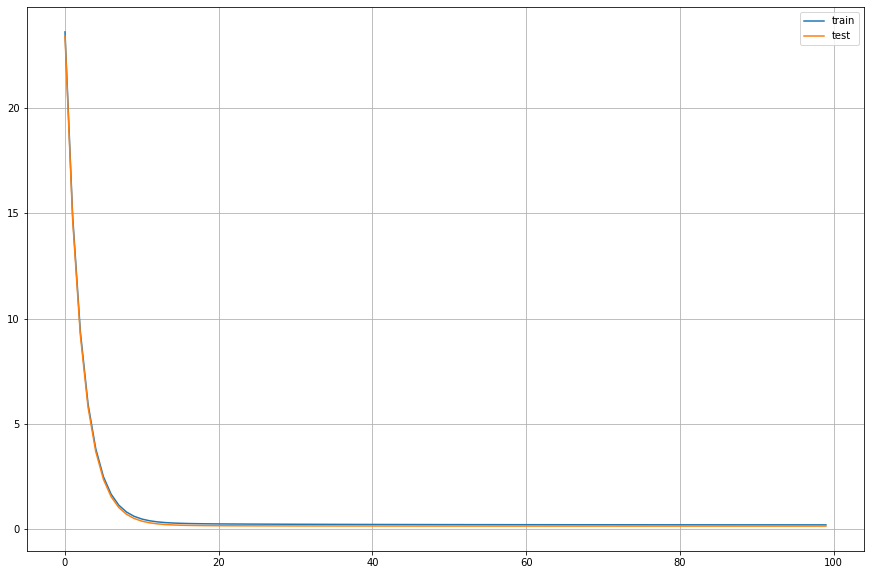

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(15,10))
plt.grid()

plt.plot(mse_train, label = 'train')
plt.plot(mse_test, label = 'test')
plt.legend()

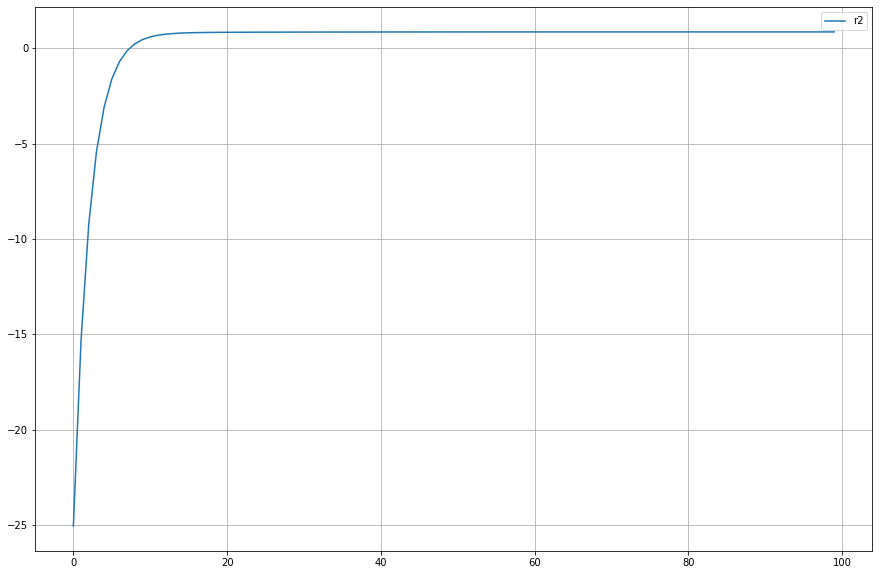

In [ ]:
from matplotlib.pyplot import figure

plt.figure(figsize=(15,10))
plt.grid()

plt.plot(r2, label = 'r2')
plt.legend()

In [ ]:
print('веса', w)
print('R^2 = ', r2_score(y_test, np.dot(X_test,w)))

веса [0.19920342 0.16338294 0.05843205 0.03381997 0.14015397 0.36690928
 0.08451803]
R^2 =  0.8100910729862933


In [ ]:
# массив результатов
r2_shuffles = []
# проверим, зависит ли изначальная перемешка от результата
for i in range(20):
    print(f'Итерация {i+1}')
    # перемешка
    df = df.sample(frac=1).reset_index(drop=True)
    # train test split
    df_train = df[:400]
    df_test = df[400:]
    # среднее и стандартное отклонение
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    # 0 мат ожидание и 1 дисперсию
    df_train = (df_train - mean)/std
    X_train = df_train.drop(columns=['Chance of Admit ']).values
    y_train = df_train['Chance of Admit '].values
    df_test = (df_test - mean)/std
    X_test = df_test.drop(columns=['Chance of Admit ']).values
    y_test = df_test['Chance of Admit '].values

    w, mse_train, mse_test, r2 = sgd(X_train, y_train, np.ones(X_train.shape[1]))
    print(f'Итерация {i+1} | R^2 = ', r2_score(y_test, np.dot(X_test,w)))
    r2_shuffles.append(r2_score(y_test, np.dot(X_test,w)))

Выполнено: 99 %
Mse train: 0.193805864844928
Mse test: 0.13530780357497751
R2: 0.849575836956934
Итерация 20 | R^2 =  0.8495706250944738


NameError: ignored

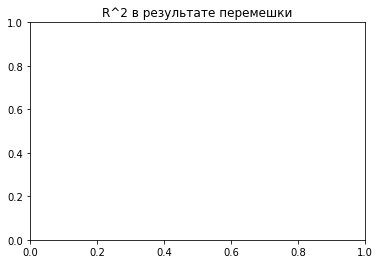

In [24]:
fig1, ax1 = plt.subplots()
ax1.set_title('R^2 в результате перемешки')
ax1.boxplot(r2_shuffles)

Вывод: сильно зависит от перемешки -> данные нерепрезентативны -> накапливаем еще или аугментируем

## Обучение с помощью sklearn

In [27]:
from sklearn.linear_model import SGDRegressor
# инициализируем и обучаем
reg = SGDRegressor()
reg.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [28]:
print('Mse sgd (sklearn): ', r2_score(y_test, reg.predict(X_test)))

Mse sgd (sklearn):  0.736798764746428


Настраиваем тонко

In [29]:
from sklearn.model_selection import GridSearchCV

grid = {'penalty': ['l1', 'l2'],
        'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

reg = SGDRegressor()
gs = GridSearchCV(reg, grid, cv=5)

# Обучаем его
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'alpha': 1e-06, 'penalty': 'l1'}, 0.8275728501777981)

In [30]:
from sklearn.linear_model import SGDRegressor
# инициализируем и обучаем
reg = SGDRegressor(alpha = 1e-05, penalty = 'l2')
reg.fit(X_train, y_train)

SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [31]:
print('Mse sgd (sklearn): ', r2_score(y_test, reg.predict(X_test)))

Mse sgd (sklearn):  0.7376345462608263


In [32]:
fin_score = []

for i in range(30):
    print(f'Итерация {i+1}')
    # перемешка
    df = df.sample(frac=1).reset_index(drop=True)
    # train test split
    df_train = df[:400]
    df_test = df[400:]
    # среднее и стандартное отклонение
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    # 0 мат ожидание и 1 дисперсию
    df_train = (df_train - mean)/std
    X_train = df_train.drop(columns=['Chance of Admit ']).values
    y_train = df_train['Chance of Admit '].values
    df_test = (df_test - mean)/std
    X_test = df_test.drop(columns=['Chance of Admit ']).values
    y_test = df_test['Chance of Admit '].values

    # обучение
    grid = {'penalty': ['l1', 'l2'],
            'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

    reg = SGDRegressor()
    gs = GridSearchCV(reg, grid, cv=5, scoring = 'r2')

    # Обучаем его
    gs.fit(X_train, y_train)
    print(gs.best_score_)
    fin_score.append(gs.best_score_)

Итерация 1
0.8131410804351189
Итерация 2
0.8066245785360007
Итерация 3
0.8124214464036588
Итерация 4
0.7995550285341362
Итерация 5
0.8273105989342502
Итерация 6
0.8145628806908792
Итерация 7
0.8058685067980396
Итерация 8
0.8119872436021935
Итерация 9
0.832390283141495
Итерация 10
0.7931773368223778
Итерация 11
0.8128103124985018
Итерация 12
0.8031294505378417
Итерация 13
0.7972540474148324
Итерация 14
0.8127145145643935
Итерация 15
0.7928835562004137
Итерация 16
0.8059375345946884
Итерация 17
0.811171858797113
Итерация 18
0.8120455702153613
Итерация 19
0.8051073466294951
Итерация 20
0.8181868360512399
Итерация 21
0.8062170838510878
Итерация 22
0.7984204190795579
Итерация 23
0.7961567313211877
Итерация 24
0.8028022517784171
Итерация 25
0.7993108626574957
Итерация 26
0.8155857056573579
Итерация 27
0.8131436770624052
Итерация 28
0.8175650817123064
Итерация 29
0.8163042555040073
Итерация 30
0.8239480428801595


{'boxes': [<matplotlib.lines.Line2D at 0x7fe0c7ac7710>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe0c7ad0f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe0c7ad0ba8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe0c7ad0128>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe0c7ac7048>,
  <matplotlib.lines.Line2D at 0x7fe0c7ad0b70>]}

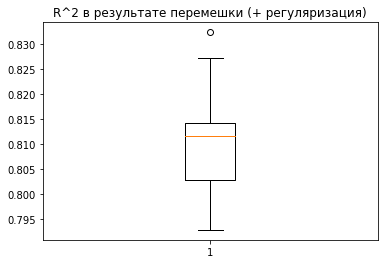

In [33]:
fig1, ax1 = plt.subplots()
ax1.set_title('R^2 в результате перемешки (+ регуляризация)')
ax1.boxplot(fin_score)

# Работа с линейными методами

На основе https://www.kaggle.com/zynicide/wine-reviews#winemag-data_first150k.csv

In [ ]:
# импортируем зависимости
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/winemag-data-130k-v2.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Корректно ли все загрузилось, сколько пропусков?

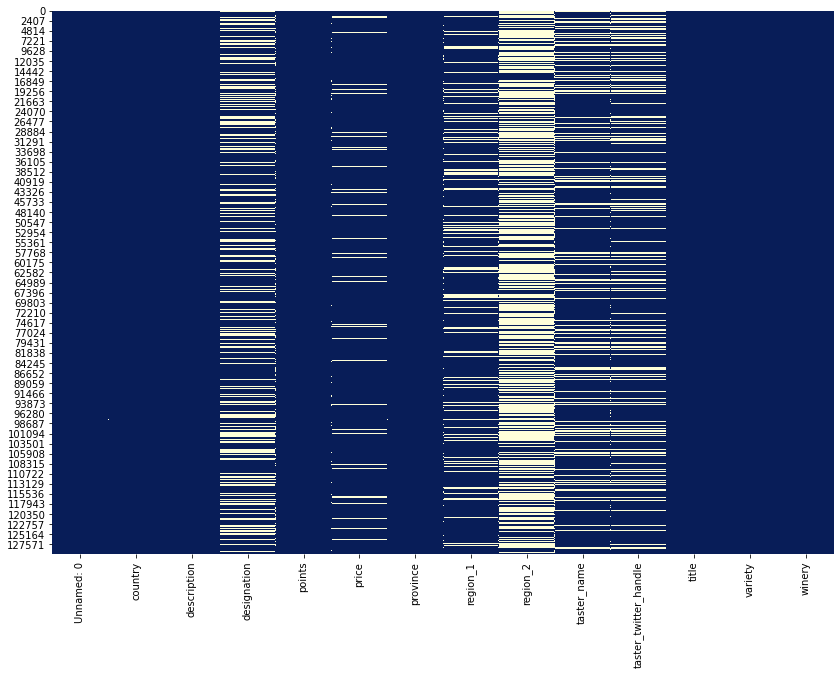

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Нам важно, чтоб был столбец цены. Столбцы region_2 (2й регион), taster_name (имя тестировщика), taster_twitter_handle (твиттер тестировщика), designation (назначение) нам не особо важны. Остальные стобцы почистим

In [ ]:
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)
df.head()

,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


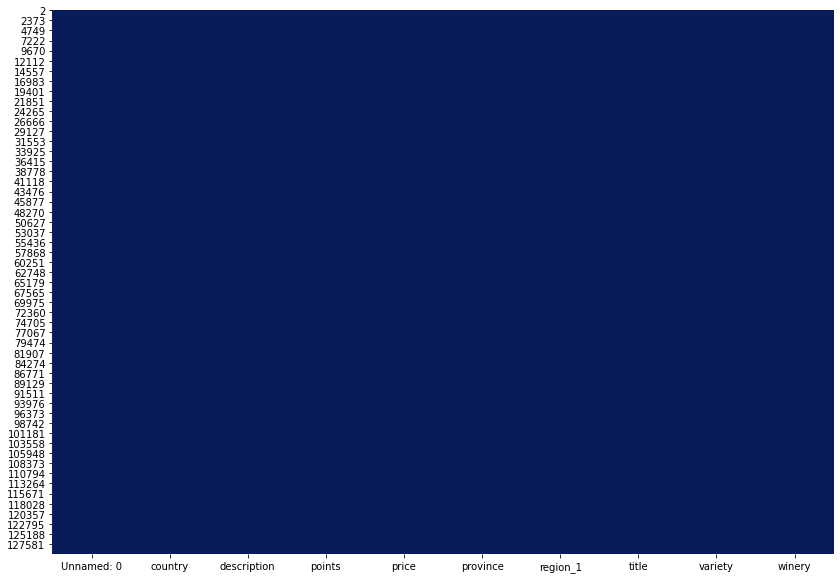

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101400 entries, 2 to 129970
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   101400 non-null  int64  
 1   country      101400 non-null  object 
 2   description  101400 non-null  object 
 3   points       101400 non-null  int64  
 4   price        101400 non-null  float64
 5   province     101400 non-null  object 
 6   region_1     101400 non-null  object 
 7   title        101400 non-null  object 
 8   variety      101400 non-null  object 
 9   winery       101400 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 8.5+ MB


In [ ]:
len(df)

101400

## Графическое исследование данных

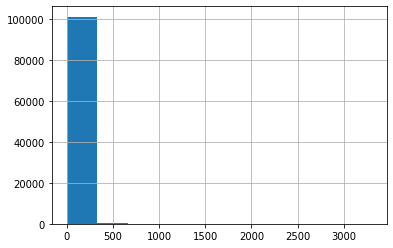

In [ ]:
df['price'].hist()

Давайте отфильтруем очень дорогие и посмотрим на обычный ценовой диапазон

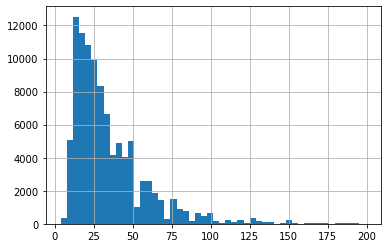

In [ ]:
df[df['price'] < 200]['price'].hist(bins = 50)

In [ ]:
# посмотрим на основную информацию
df['price'].describe()

count    101400.000000
mean         36.936558
std          41.895979
min           4.000000
25%          18.000000
50%          28.000000
75%          45.000000
max        3300.000000
Name: price, dtype: float64

Медиана ~28 за бутылку, средняя ~37, стандартное отклонение ~42 (в $)

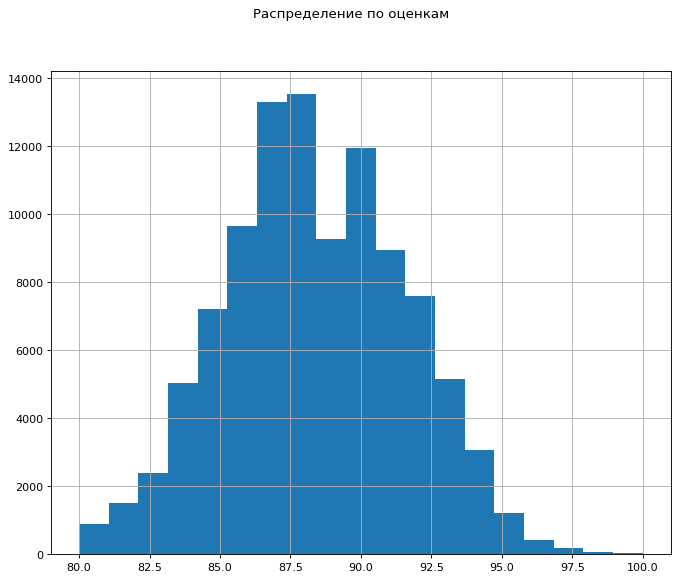

In [ ]:
from matplotlib.pyplot import figure
import pylab as pl
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
pl.suptitle("Распределение по оценкам")
df['points'].hist(bins=19)

In [ ]:
df['points'].describe()

count    101400.000000
mean         88.463343
std           3.060467
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

Самая ценная информация хранится в текстовом обзоре, попробуем его предобработать "по старинке"

In [ ]:
import string
# реализуем предобработку
def preprocess(doc):
    # к нижнему регистру
    doc = doc.lower()
    # убираем пунктуацию, пробелы, прочее
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # убираем лишние пробелы, объединяем обратно
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [ ]:
# найдем все стобцы с типом данных строки
df.select_dtypes(include= np.object)

,country,description,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
...,...,...,...,...,...,...,...
129965,France,"While it's rich, this beautiful dry wine also ...",Alsace,Alsace,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann
129967,US,Citation is given as much as a decade of bottl...,Oregon,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Alsace,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Alsace,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [ ]:
#  применим к этим столбцам нашу функцию понижения текста
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

NameError: ignored

Что можно сделать с текстом? Преобразовать его в матрицу tfidf, которая каждому слову в тексте выставит его меру tfidf:

Каждому тексту (набору слов) ставит в соответсвие вектор (набор цифр, по одной для каждого слова): text -> vector $v$ from $R^N$ where $N$ is a vocabulary size.

$TF-IDF(token, document) = TF(token, document) * IDF(token, document)$

$TF$ Частотность термина - кол-во встречаний в выбранном документе (в нашем случае описании):

$TF(token, document) = \frac{n_{token}}{\sum_{k}n_k}.$

$IDF$ обратная частота - логарифм от (количества документов) / (кол-во документов, где появлялось слово)

$IDF(token, all\_documents) = \log\frac{Total\ number\ of\ documents}{number\ of\ documents\ where\ token\ appeared}.$

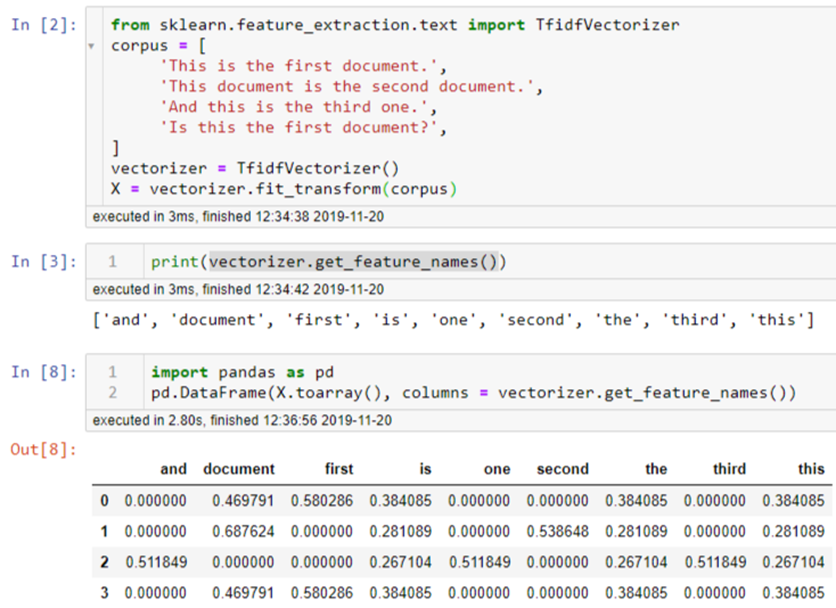

Для оперативности вычислений перемешаем обзоры и возьмем 20 тысяч из них:

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[:10000]

In [ ]:
df.head()

,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


In [ ]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

# инициализировали алгоритм
vectorizer = TfidfVectorizer()
# преобразовали его в матрицу tfidf как в примере на картинке выше
X_np = vectorizer.fit_transform(df['description'].values)
# отобразили его размерность
print(X_np.shape)

KeyError: ignored

In [ ]:
# т.к. сам тип матрицы из scipy - преобразуем в tfidf
X_np = X_np.toarray()

Мы получили преобразованные описания в виде набор из 15263 столбцов, которые отвечают уникальным словам в этом описании. Сами слова можно найти через vectorizer.get_feature_names()

In [ ]:
# отобразим произвольные слова
print(vectorizer.get_feature_names()[13000:13010])

['succeed', 'succeeded', 'succeeds', 'success', 'successes', 'successful', 'successfully', 'succession', 'successive', 'successor']


## Для начала решим задачу задачу без текстовых описаний

## Классификация

### Подготовка данных

Давайте для начала будем решать задачу кластеризации. Разделим наши оценки вина от 1 до 5, где 5 - максимальная, 1 - минимальная (исходя из колонки points)

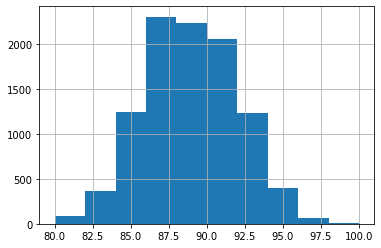

In [ ]:
df['points'].hist()

С учетом этого распределения оценки будут следующие
* 1: 80-85 - очень плохое вино
* 2: 85-88 - плохое вино
* 3: 88-92 - среднестатистическое вино
* 4: 92-95 - хорошее вино
* 5: 95-100 - очень хорошее

In [ ]:
def make_class(point):
    if point < 85:
        return 1
    elif point >= 85 and point < 88:
        return 2
    elif point >= 88 and point < 92:
        return 3
    elif point >= 92 and point < 95:
        return 4
    elif point >= 95:
        return 5

df['points'] = df['points'].apply(make_class)
df.head(10)

,Unnamed: 0,country,description,points,price,province,region_1,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",2,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",2,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",2,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,2,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",2,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,2,24.0,Alsace,Alsace,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
9,9,France,This has great depth of flavor with its fresh ...,2,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,10,US,"Soft, supple plum envelopes an oaky structure ...",2,19.0,California,Napa Valley,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
11,11,France,"This is a dry wine, very spicy, with a tight, ...",2,30.0,Alsace,Alsace,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
12,12,US,"Slightly reduced, this wine offers a chalky, t...",2,34.0,California,Alexander Valley,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


In [ ]:
df['points'].value_counts()

3    43671
2    30187
4    15779
1     9828
5     1935
Name: points, dtype: int64

In [ ]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,Unnamed: 0,country,points,price,province,region_1,title,variety,winery
2,2,6,2,14.0,43,1192,69940,318,10741
3,3,6,2,13.0,30,538,78569,347,11860
4,4,6,2,65.0,43,1192,80105,322,12038
5,5,5,2,15.0,39,739,80765,430,12107
6,6,4,2,16.0,50,1179,82494,131,12369


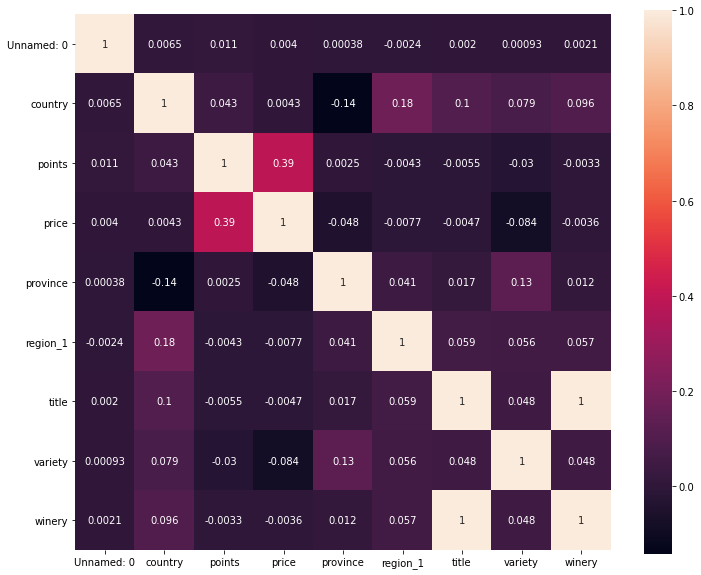

In [ ]:
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square = True, annot=True)
plt.show()

In [ ]:
encoded_data.drop(columns=['winery', 'Unnamed: 0'], inplace=True)
encoded_data.head()

,country,points,price,province,region_1,title,variety
2,6,2,14.0,43,1192,69940,318
3,6,2,13.0,30,538,78569,347
4,6,2,65.0,43,1192,80105,322
5,5,2,15.0,39,739,80765,430
6,4,2,16.0,50,1179,82494,131


In [ ]:
# выделим целевую переменную - качество
y = np.array(encoded_data['points'])

In [ ]:
y

array([2, 2, 2, ..., 3, 3, 3])

In [ ]:
X = np.array(encoded_data.drop(columns=['points']), float)
X

array([[6.0000e+00, 1.4000e+01, 4.3000e+01, 1.1920e+03, 6.9940e+04,
        3.1800e+02],
       [6.0000e+00, 1.3000e+01, 3.0000e+01, 5.3800e+02, 7.8569e+04,
        3.4700e+02],
       [6.0000e+00, 6.5000e+01, 4.3000e+01, 1.1920e+03, 8.0105e+04,
        3.2200e+02],
       ...,
       [3.0000e+00, 3.0000e+01, 0.0000e+00, 2.1000e+01, 2.8812e+04,
        1.4900e+02],
       [3.0000e+00, 3.2000e+01, 0.0000e+00, 2.1000e+01, 2.9266e+04,
        3.1800e+02],
       [3.0000e+00, 2.1000e+01, 0.0000e+00, 2.1000e+01, 2.9793e+04,
        1.4900e+02]])

In [ ]:
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(X)*0.8)]

X_test = X[int(len(X)*0.8):]
y_test = y[int(len(X)*0.8):]

### Нормализация

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [ ]:
mean, std

(array([4.73280325e+00, 3.68030942e+01, 2.72156681e+01, 6.05370242e+02,
        4.61992671e+04, 2.52661033e+02]),
 array([1.61747236e+00, 4.13972237e+01, 2.17038192e+01, 3.69230286e+02,
        2.67082658e+04, 1.46607781e+02]))

In [ ]:
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(81120, 6) (20280, 6) (81120,) (20280,)


### Алгоритмы

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

### KNN

In [ ]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
knn_grid = {'n_neighbors': np.array(np.linspace(30, 50, 20), dtype='int')}
gs = GridSearchCV(knn, knn_grid)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'n_neighbors': 40}, 0.507310157790927)

In [ ]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

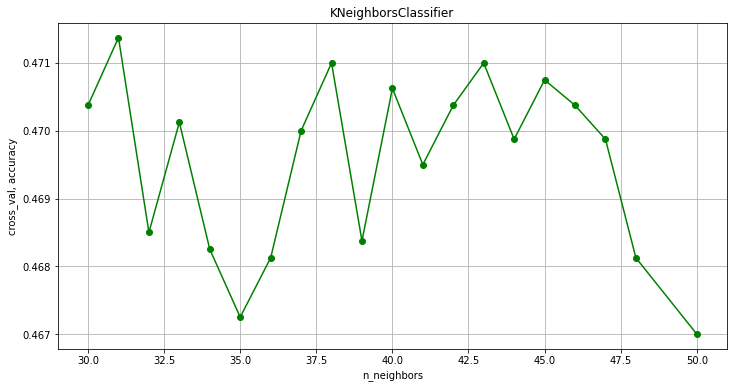

In [ ]:
# Строим график зависимости качества от числа соседей
# замечание: результаты обучения хранятся в атрибуте cv_results_ объекта gs
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=31, n_jobs=4)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=31, p=2,
                     weights='uniform')

In [ ]:
preds = knn.predict(X_test)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.36      0.09      0.15       190
           2       0.46      0.41      0.43       590
           3       0.50      0.75      0.60       874
           4       0.44      0.14      0.22       308
           5       0.57      0.11      0.18        38

    accuracy                           0.48      2000
   macro avg       0.46      0.30      0.31      2000
weighted avg       0.46      0.48      0.44      2000



## SVM

In [ ]:
alg = SVC()

grid = {'C': np.array(np.linspace(-5, 5, 10), dtype='float'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


({'C': 5.0, 'kernel': 'rbf'}, 0.49487500000000006)

In [ ]:
svm = SVC(C=5, kernel = 'rbf')

svm.fit(X_train, y_train)

In [ ]:
preds = svm.predict(X_test)

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

## Логистическая

In [ ]:
alg = LogisticRegression()

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
        }

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.8s finished


({'C': 2.1544346900318843, 'penalty': 'l2'}, 0.501625)

In [ ]:
logreg = LogisticRegression(penalty='l2', C = 2.1544346900318843)

logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       190
           2       0.47      0.52      0.50       590
           3       0.53      0.75      0.62       874
           4       0.50      0.18      0.26       308
           5       0.57      0.11      0.18        38

    accuracy                           0.51      2000
   macro avg       0.42      0.31      0.31      2000
weighted avg       0.46      0.51      0.46      2000



## Регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {'penalty': ['l1', 'l2'],
        'alpha': [1e-4, 1e-5, 1e-6, 1e-7]}

reg = SGDRegressor()
gs = GridSearchCV(reg, grid, verbose = 2, scoring = 'r2')

# Обучаем его
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l1 ........................................
[CV] ......................... alpha=0.0001, penalty=l1, total=   0.0s
[CV] alpha=0.0001, penalty=l2 ........................................
[CV] ......................... alpha=0.0001, penalty=l2, total=   0.0s
[CV] alpha=0.0001, penalty=l2 ........................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... alpha=0.0001, penalty=l2, total=   0.0s
[CV] alpha=0.0001, penalty=l2 ........................................
[CV] ......................... alpha=0.0001, penalty=l2, total=   0.0s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l1 .........................................
[CV] .......................... alpha=1e-05, penalty=l1, total=   0.0s
[CV] alpha=1e-05, penalty=l2 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.9s finished


({'alpha': 0.0001, 'penalty': 'l2'}, 0.25225838384529176)

In [ ]:
reg = SGDRegressor(alpha = 1e-4, penalty='l2')
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
print('R2 sgd (sklearn): ', r2_score(y_test, preds))

Mse sgd (sklearn):  0.28284205548809493


(array([  1.,   3.,  14.,  66., 214., 492., 582., 409., 193.,  26.]),
 array([-12.58485736, -10.62929888,  -8.67374041,  -6.71818193,
         -4.76262346,  -2.80706498,  -0.85150651,   1.10405197,
          3.05961044,   5.01516891,   6.97072739]),
 <a list of 10 Patch objects>)

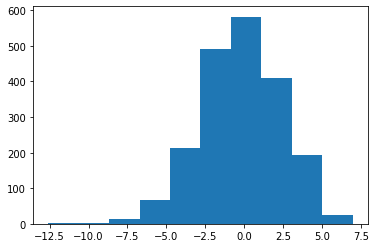

In [ ]:
plt.hist(y_test - preds)

In [ ]:

reg = GradientBoostingRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

In [ ]:
print('R2 gb: ', r2_score(y_test, preds))

R2 gb:  0.41991838285645655


(array([  5.,  23.,  66., 176., 387., 535., 444., 266.,  87.,  11.]),
 array([-8.92053427, -7.35669345, -5.79285262, -4.2290118 , -2.66517098,
        -1.10133015,  0.46251067,  2.02635149,  3.59019232,  5.15403314,
         6.71787396]),
 <a list of 10 Patch objects>)

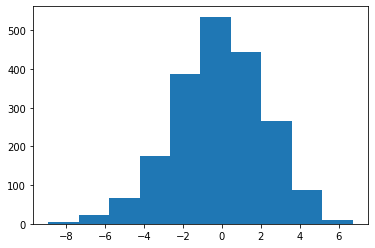

In [ ]:
plt.hist(y_test - preds)

(array([  8., 171., 289., 463., 390., 305., 237., 111.,  19.,   7.]),
 array([83.47890802, 84.62082988, 85.76275175, 86.90467362, 88.04659549,
        89.18851736, 90.33043922, 91.47236109, 92.61428296, 93.75620483,
        94.8981267 ]),
 <a list of 10 Patch objects>)

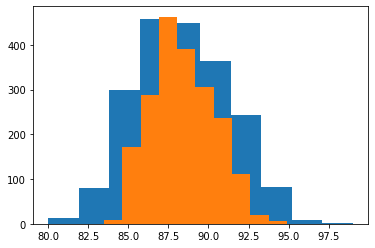

In [ ]:
plt.hist(y_test)
plt.hist(preds)

## Data+tfidf

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tixonsit/mmdad_materials/master/winemag-data-130k-v2.csv', index_col='Unnamed: 0')

In [ ]:
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


In [ ]:
df['points'] = df['points'].apply(make_class)
df.head(10)

NameError: ignored

In [ ]:
df.points.value_counts()

3    43671
2    30187
4    15779
1     9828
5     1935
Name: points, dtype: int64

In [ ]:
#  применим к этим столбцам нашу функцию понижения текста
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,2,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,2,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,2,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,2,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,2,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo


In [ ]:
from sklearn import preprocessing

In [ ]:
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

In [ ]:
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
2,6,2,14.0,43,1192,69968,319,10714
3,6,2,13.0,30,538,78601,347,11833
4,6,2,65.0,43,1192,80139,323,12012
5,5,2,15.0,39,739,80785,430,12075
6,4,2,16.0,50,1179,82412,131,12334


In [ ]:
y = np.array(encoded_data.points)
del encoded_data['points']

In [ ]:
encoded_data

,country,price,province,region_1,title,variety,winery
2,6,14.0,43,1192,69968,319,10714
3,6,13.0,30,538,78601,347,11833
4,6,65.0,43,1192,80139,323,12012
5,5,15.0,39,739,80785,430,12075
6,4,16.0,50,1179,82412,131,12334
...,...,...,...,...,...,...,...
129965,3,28.0,0,21,30463,319,5421
129967,6,75.0,43,769,22660,323,4026
129968,3,30.0,0,21,29632,149,5246
129969,3,32.0,0,21,30149,319,5356


In [ ]:
y

array([2, 2, 2, ..., 3, 3, 3])

In [ ]:
encoded_data = encoded_data[:20000]

In [ ]:
y = y[:20000]

In [ ]:
X_train = encoded_data.values[:int(len(encoded_data.values)*0.8)]
y_train = y[:int(len(encoded_data.values)*0.8)]

X_test = encoded_data.values[int(len(encoded_data.values)*0.8):]
y_test = y[int(len(encoded_data.values)*0.8):]

In [ ]:
X_train.shape, y_train.shape

((16000, 7), (16000,))

In [ ]:
pd.Series(y_train).value_counts()

3    6591
2    4945
4    2560
1    1633
5     271
dtype: int64

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

In [ ]:
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
df['description']

2         tart and snappy the flavors of lime flesh and ...
3         pineapple rind lemon pith and orange blossom s...
4         much like the regular bottling from 2012 this ...
5         blackberry and raspberry aromas show a typical...
6         here s a bright informal red that opens with a...
                                ...                        
129965    while it s rich this beautiful dry wine also o...
129967    citation is given as much as a decade of bottl...
129968    well drained gravel soil gives this wine its c...
129969    a dry style of pinot gris this is crisp with s...
129970    big rich and off dry this is powered by intens...
Name: description, Length: 101400, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
# преобразовали его в матрицу tfidf как в примере на картинке выше
X_np = vectorizer.fit_transform(df['description'][:20000].values)
# отобразили его размерность
print(X_np.shape)

(20000, 15175)


In [ ]:
X_train.shape

(16000, 7)

In [ ]:
X_train = np.append(X_train, X_np.toarray()[:16000], axis=1)


In [ ]:
X_test = np.append(X_test, X_np.toarray()[16000:], axis=1)

In [ ]:
X_train.shape

(16000, 15182)

In [ ]:
X_test.shape

(4000, 15182)